In [63]:
import pandas as pd
import numpy as np
from glob import glob
import cv2

import matplotlib.pyplot as plt
from tqdm import tqdm

import timm
import torch

import pickle

In [2]:
df_original = pd.read_csv("/workspace/data/df_train_study_level_npy640_3_w_bbox.csv")
df_original.head()

id           x           y          w           h  \
0  04f41a8958f7_image   688.06282   966.82563  518.48212  1130.17438   
1  04f41a8958f7_image  2482.36026  1636.77436  652.47168   652.47168   
2  04f41a8958f7_image  1235.67308  1628.03597  509.74353   559.26147   
3  0572ef0d0c1a_image  1818.65264   233.50598  613.04395   839.53784   
4  0572ef0d0c1a_image   598.60492    61.37052  688.54175   881.81674   

       study_id      image_id  have_box  \
0  6e4a0581cefe  04f41a8958f7         1   
1  6e4a0581cefe  04f41a8958f7         1   
2  6e4a0581cefe  04f41a8958f7         1   
3  adbfed2da701  0572ef0d0c1a         1   
4  adbfed2da701  0572ef0d0c1a         1   

                                          dicom_path  Negative for Pneumonia  \
0  /workspace/data/train/6e4a0581cefe/018ed20fa9c...                       0   
1  /workspace/data/train/6e4a0581cefe/018ed20fa9c...                       0   
2  /workspace/data/train/6e4a0581cefe/018ed20fa9c...                       0   
3  /workspace/data/train/adbfed2da701/e2fa197720c...                       0   
4  /workspace/data/train/adbfed2da701/e2fa197720c...                       0   

   Typical Appearance  Indeterminate Appearance  Atypical Appearance  cv  \
0                   1                         0                    0   0   
1                   1                         0                    0   0   
2                   1                         0                    0   0   
3                   1                         0                    0   3   
4                   1                         0                    0   3   

                                       npy_path  is_none  
0  /workspace/data/train_640_2/04f41a8958f7.png        0  
1  /workspace/data/train_640_2/04f41a8958f7.png        0  
2  /workspace/data/train_640_2/04f41a8958f7.png        0  
3  /workspace/data/train_640_2/0572ef0d0c1a.png        0  
4  /workspace/data/train_640_2/0572ef0d0c1a.png        0

In [3]:
bimcv_path = glob('/workspace/data/external/bimcv/covid19_posi_dump/*png')
record_path = glob('/workspace/data/external/record/MIDRC-RICORD/MIDRC-RICORD/*jpg')

In [4]:
print(len(bimcv_path))
print(len(record_path))

16840
1022


In [20]:
device = "cuda:0"

eff = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)
extractor = torch.nn.Sequential(*list(eff.children())[:-1]).to(device)
extractor.eval()

Sequential(
  (0): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(
        (conv_dw):

In [26]:
record_img_array = []
for i in tqdm(range(len(record_path))):
    img_hash = cv2.imread(record_path[i])
    img_hash = cv2.resize(img_hash, (512, 512)).transpose(2, 0, 1)[None, :, :]
    
    img_tensor = torch.tensor(img_hash, dtype=torch.float).to(device)
    fe = extractor(img_tensor).cpu().detach().numpy()
    
    record_img_array.append(fe)
    
record_img_array = np.array(record_img_array)

100%|██████████| 1022/1022 [01:35<00:00, 10.66it/s]


In [27]:
bimcv_img_array = []
for i in tqdm(range(len(bimcv_path))):
    img_hash = cv2.imread(bimcv_path[i])
    img_hash = cv2.resize(img_hash, (512, 512)).transpose(2, 0, 1)[None, :, :]
    
    img_tensor = torch.tensor(img_hash, dtype=torch.float).to(device)
    fe = extractor(img_tensor).cpu().detach().numpy()
    
    bimcv_img_array.append(fe)

bimcv_img_array = np.array(bimcv_img_array)

100%|██████████| 16840/16840 [05:07<00:00, 54.80it/s]


In [30]:
original_img_array = []

df_original_agg = df_original.groupby('npy_path').first().reset_index()

for i in tqdm(range(len(df_original_agg))):
    img_hash = cv2.imread(df_original_agg.npy_path[i])
    img_hash = cv2.resize(img_hash, (512, 512)).transpose(2, 0, 1)[None, :, :]
    
    img_tensor = torch.tensor(img_hash, dtype=torch.float).to(device)
    fe = extractor(img_tensor).cpu().detach().numpy()
    
    original_img_array.append(fe)
original_img_array = np.array(original_img_array)

100%|██████████| 6117/6117 [08:38<00:00, 11.80it/s]


In [33]:
record_img_array = np.array(record_img_array)[:,0,:]
bimcv_img_array = np.array(bimcv_img_array)[:,0,:]
original_img_array = np.array(original_img_array)[:,0,:]

In [62]:
np.save('/workspace/data/external/record_img_array', record_img_array)
np.save('/workspace/data/external/bimcv_img_array', bimcv_img_array)
np.save('/workspace/data/external/original_img_array', original_img_array)

In [68]:
original_path = df_original_agg.npy_path.values

threshold_min = 200

record2original_dict = {}
bimcv2original_dict = {}

for i in tqdm(range(len(df_original_agg))):

    one_image_from_original = original_img_array[i]

    r = np.abs(record_img_array - one_image_from_original).mean(1)
    b = np.abs(bimcv_img_array - one_image_from_original).mean(1)
    
    r_min = r.min()
    b_min = b.min()
    
    r_min_index = r.argsort()[0]
    b_min_index = b.argsort()[0]
    
    if r_min < threshold_min:
        record2original_dict[record_path[r_min_index]] = original_path[i]
        
    if b_min < threshold_min:
        bimcv2original_dict[bimcv_path[b_min_index]] = original_path[i]

100%|██████████| 6117/6117 [04:10<00:00, 24.39it/s]


In [69]:
with open("/workspace/data/external/record2original_dict.pkl", mode="wb") as f:
    pickle.dump(record2original_dict, f)
    
with open("/workspace/data/external/bimcv2original_dict.pkl", mode="wb") as f:
    pickle.dump(bimcv2original_dict, f)
    
    
with open("/workspace/data/external/record2original_dict.pkl", mode="rb") as f:
    record2original_dict_load = pickle.load(f)
    
with open("/workspace/data/external/bimcv2original_dict.pkl", mode="rb") as f:
    bimcv2original_dict_load = pickle.load(f)

In [74]:
len(record2original_dict)

53

In [75]:
len(bimcv2original_dict)

183

In [85]:
df_bimcv = pd.DataFrame({
    "npy_path": bimcv_path,
    "external": ["bimcv"] * len(bimcv_path)
})

df_record = pd.DataFrame({
    "npy_path": record_path,
    "external": ["record"] * len(record_path)
})


df_bimcv = df_bimcv[~df_bimcv.npy_path.isin(bimcv2original_dict.keys())].reset_index(drop=True)
df_record = df_record[~df_record.npy_path.isin(bimcv2original_dict.keys())].reset_index(drop=True)

df_ext = pd.concat([df_bimcv, df_record], axis=0, ignore_index=True)
df_ext["cv"] = [i % 5 for i in range(len(df_ext))]

In [86]:
df_ext

npy_path external  cv
0      /workspace/data/external/bimcv/covid19_posi_du...    bimcv   0
1      /workspace/data/external/bimcv/covid19_posi_du...    bimcv   1
2      /workspace/data/external/bimcv/covid19_posi_du...    bimcv   2
3      /workspace/data/external/bimcv/covid19_posi_du...    bimcv   3
4      /workspace/data/external/bimcv/covid19_posi_du...    bimcv   4
...                                                  ...      ...  ..
17674  /workspace/data/external/record/MIDRC-RICORD/M...   record   4
17675  /workspace/data/external/record/MIDRC-RICORD/M...   record   0
17676  /workspace/data/external/record/MIDRC-RICORD/M...   record   1
17677  /workspace/data/external/record/MIDRC-RICORD/M...   record   2
17678  /workspace/data/external/record/MIDRC-RICORD/M...   record   3

[17679 rows x 3 columns]

In [87]:
df_ext.to_csv('/workspace/data/external/df_ext.csv', index=False)

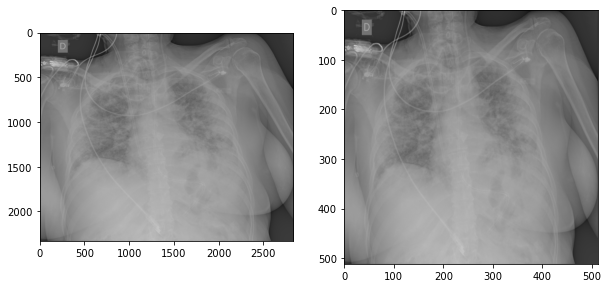

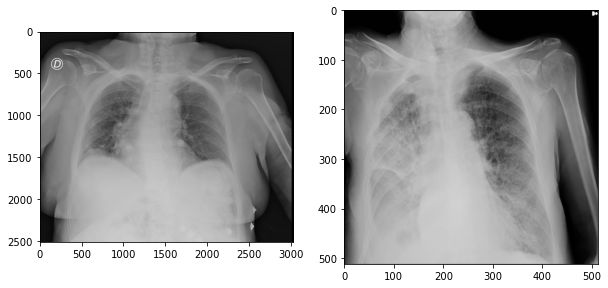

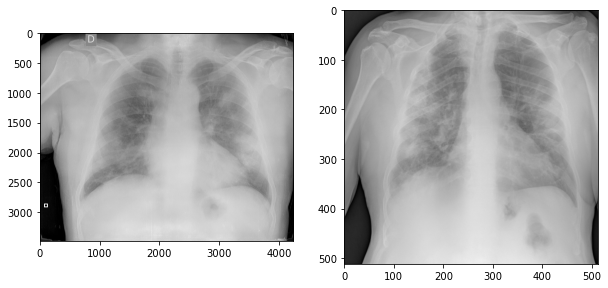

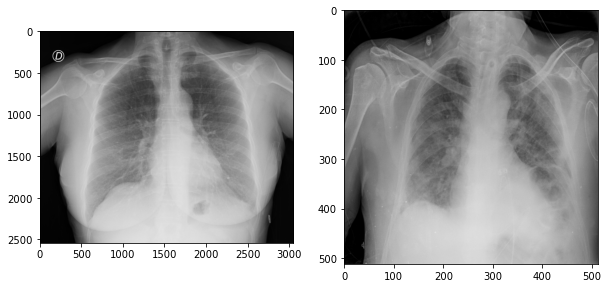

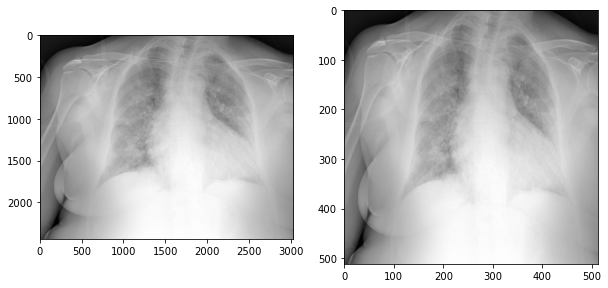

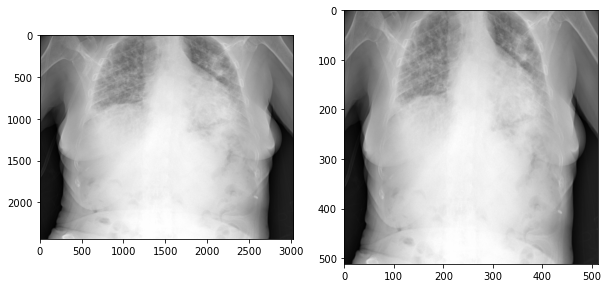

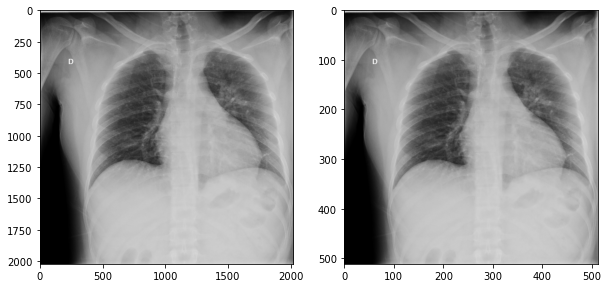

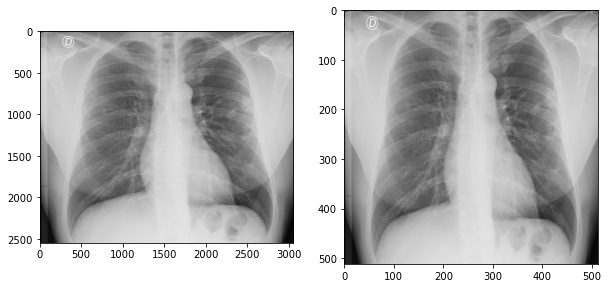

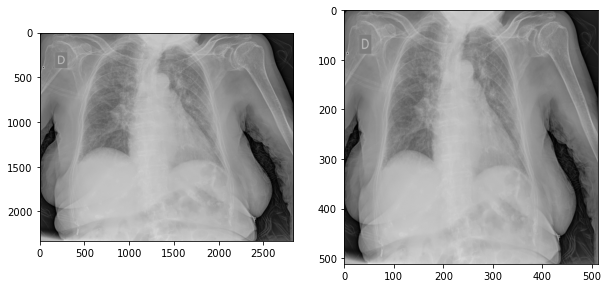

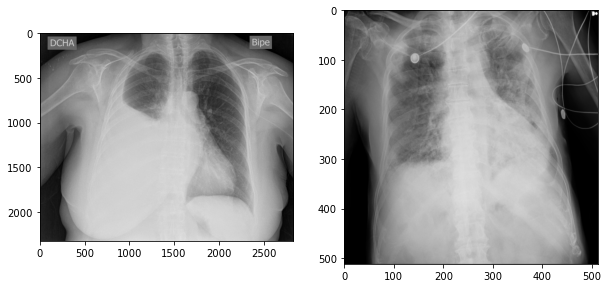

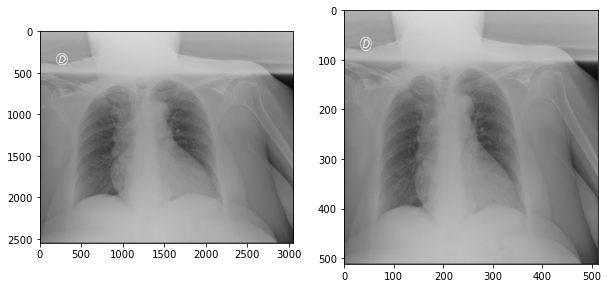

In [72]:
for i, (t, o) in enumerate(bimcv2original_dict_load.items()):
    if i > 10:
        break
    
    plt.figure(figsize=(10, 12))

    original_img = cv2.imread(o)
    target_img = cv2.imread(t)

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)

    plt.subplot(1, 2, 2)
    plt.imshow(target_img)
    plt.show()

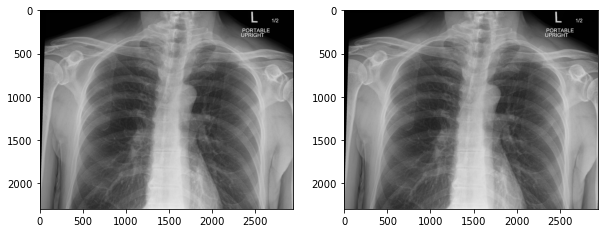

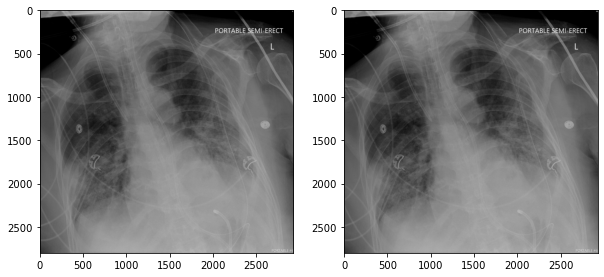

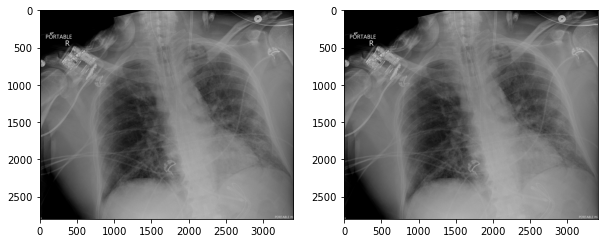

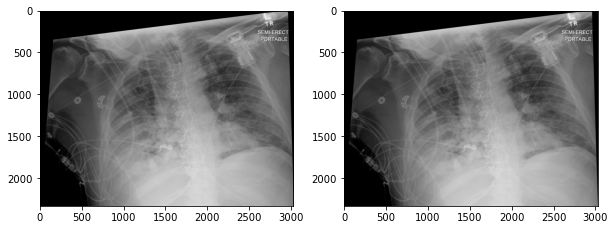

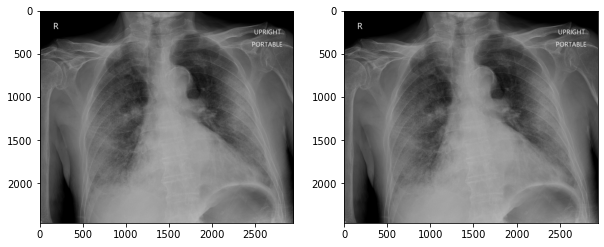

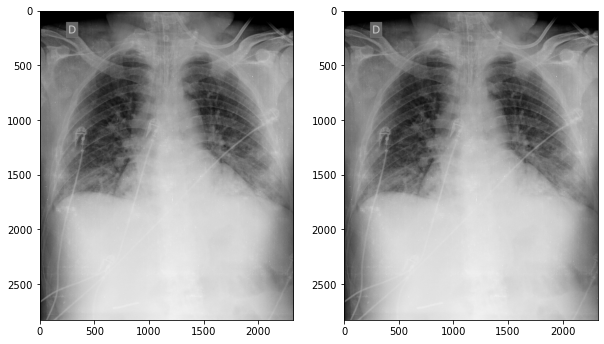

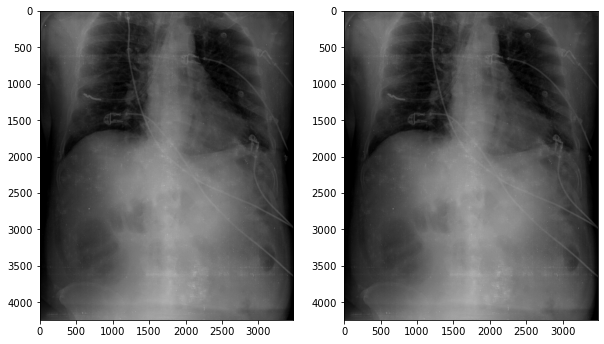

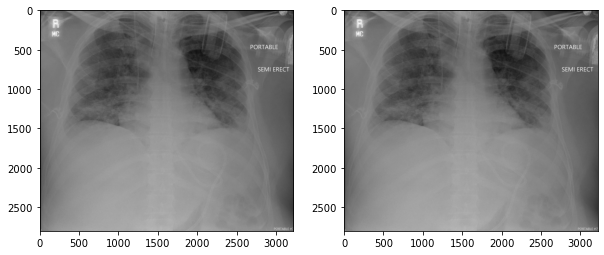

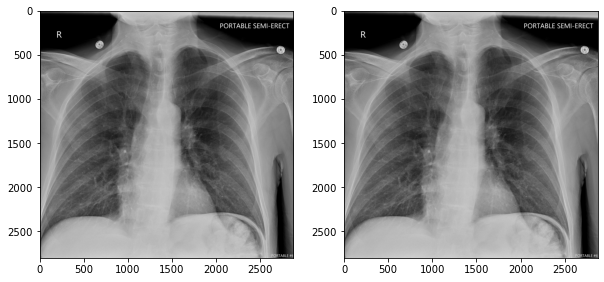

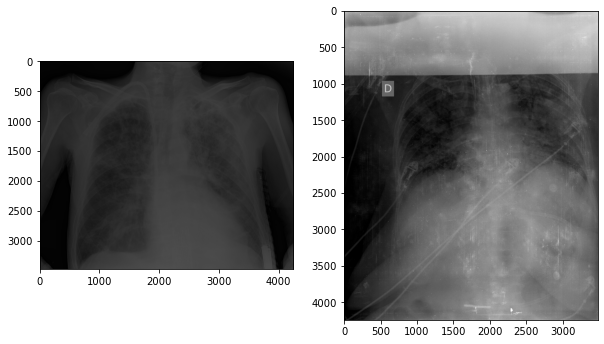

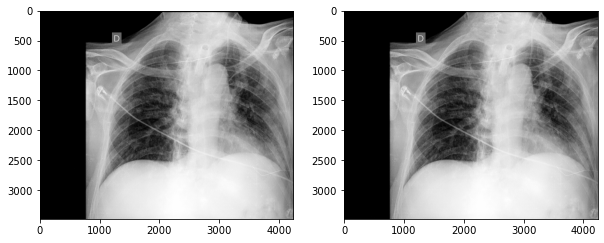

In [73]:
for i, (t, o) in enumerate(record2original_dict_load.items()):
    if i > 10:
        break
    
    plt.figure(figsize=(10, 12))

    original_img = cv2.imread(o)
    target_img = cv2.imread(t)

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)

    plt.subplot(1, 2, 2)
    plt.imshow(target_img)
    plt.show()

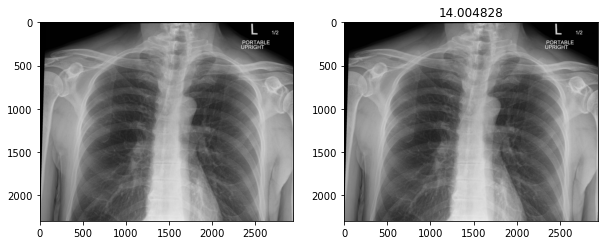

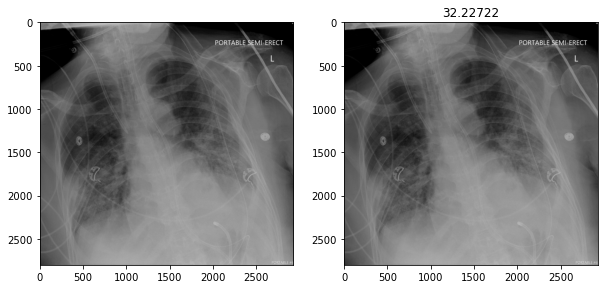

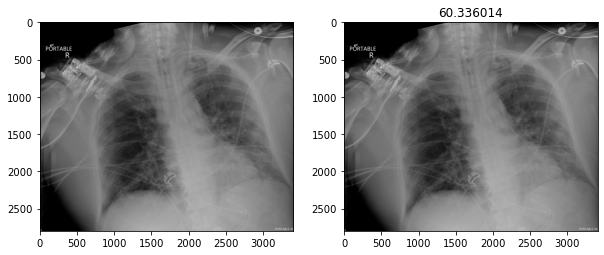

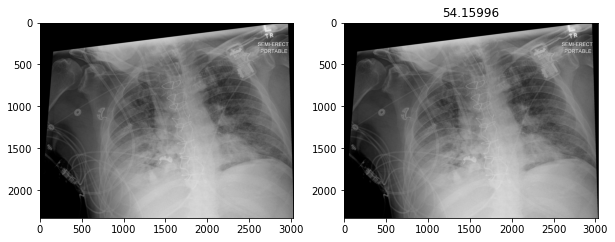

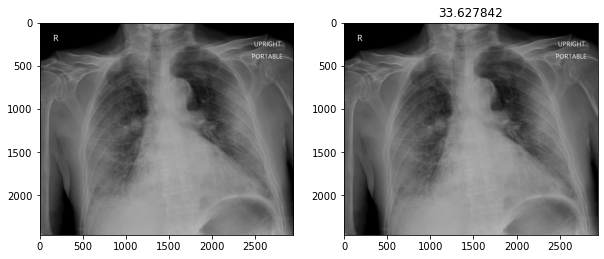

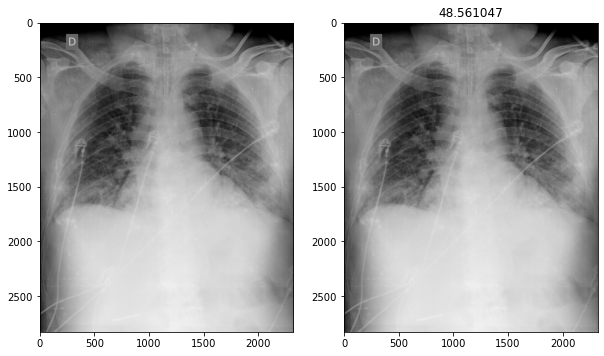

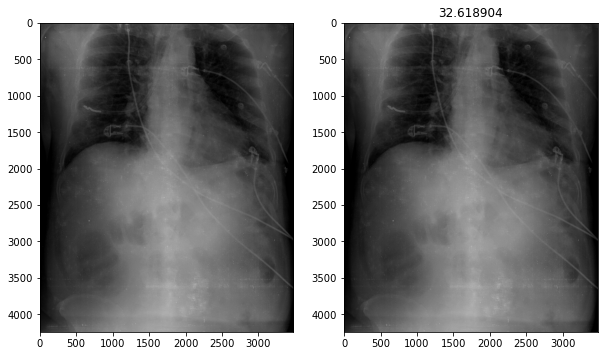

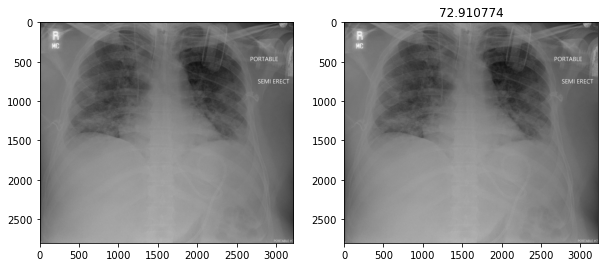

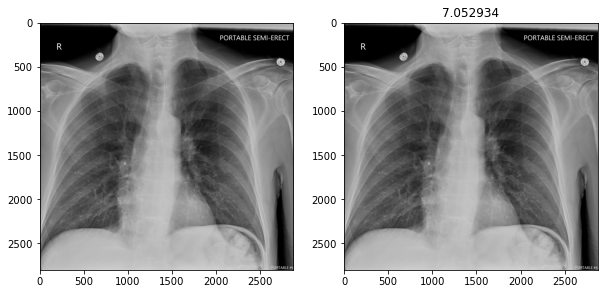

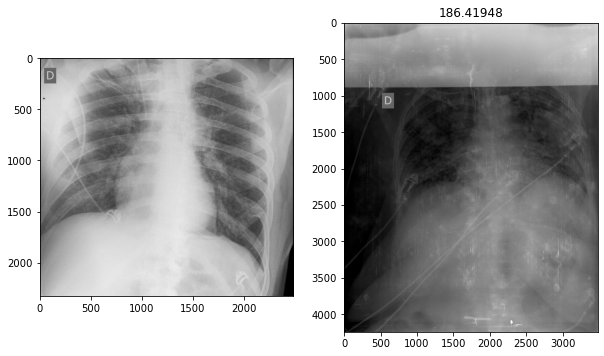

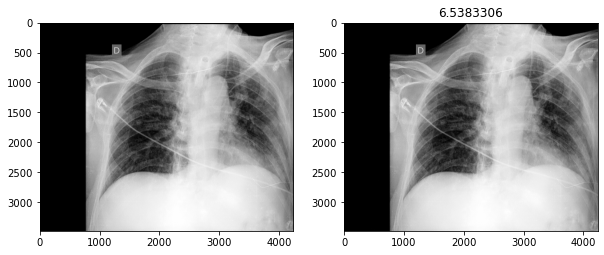

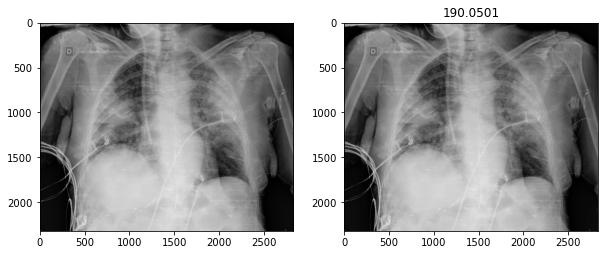

In [48]:
cnt = 0

for original_img_num in range(20000):

    if np.abs(record_img_array - original_img_array[original_img_num]).mean(1).min() < 200:
        ind = np.abs(record_img_array - original_img_array[original_img_num]).mean(1).argsort()[0]

        plt.figure(figsize=(10, 12))

        original_img = cv2.imread(df_original_agg.npy_path[original_img_num])
        target_img = cv2.imread(record_path[ind])

        plt.subplot(1, 2, 1)
        plt.imshow(original_img)

        plt.subplot(1, 2, 2)
        plt.imshow(target_img)
        plt.title(np.abs(record_img_array - original_img_array[original_img_num]).mean(1).min())
        plt.show()
    
        if cnt > 10:
            break
        else:
            cnt += 1

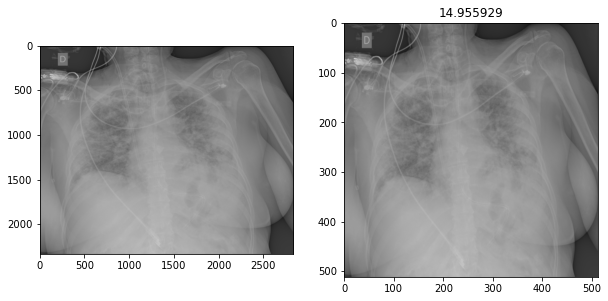

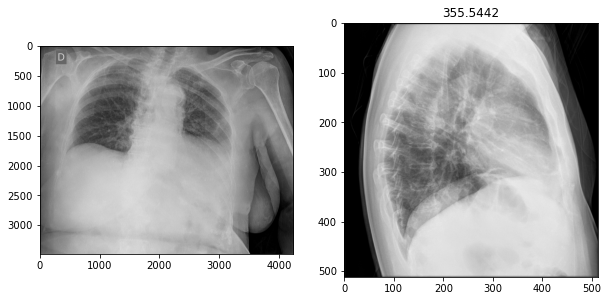

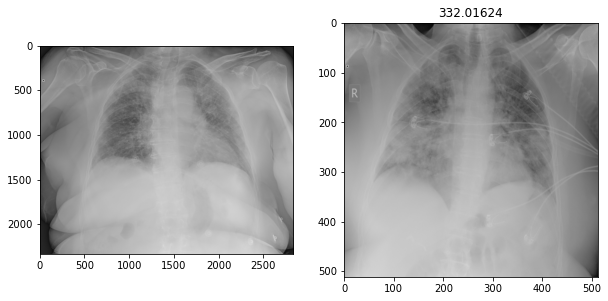

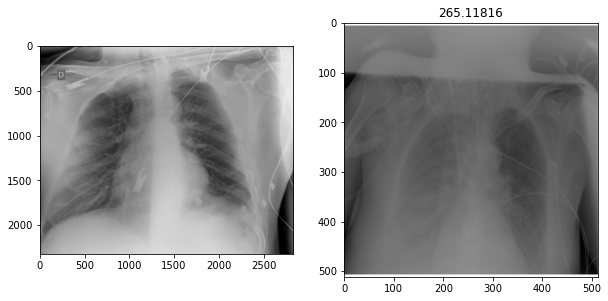

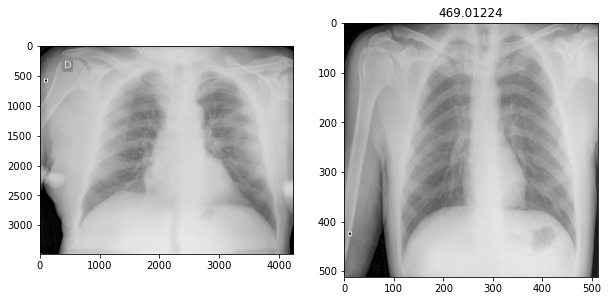

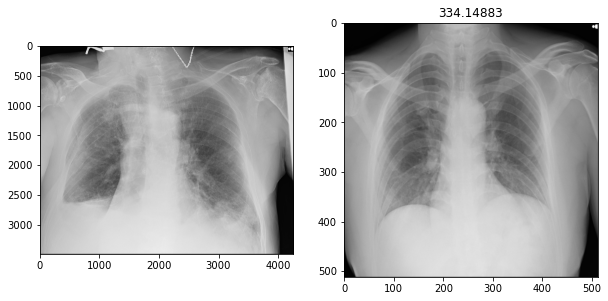

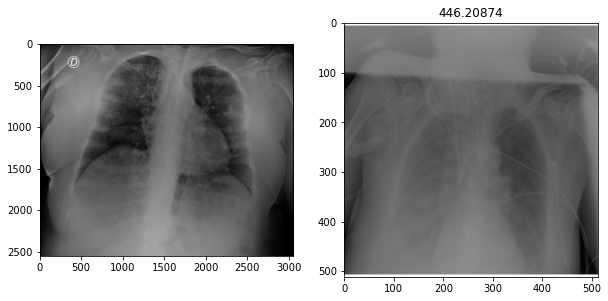

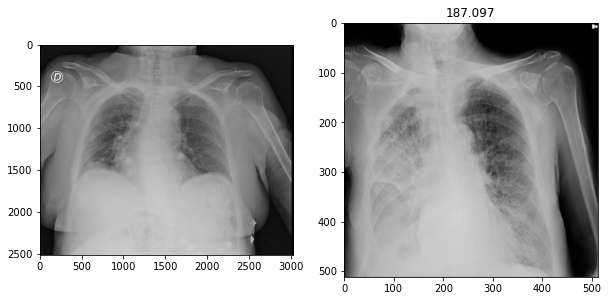

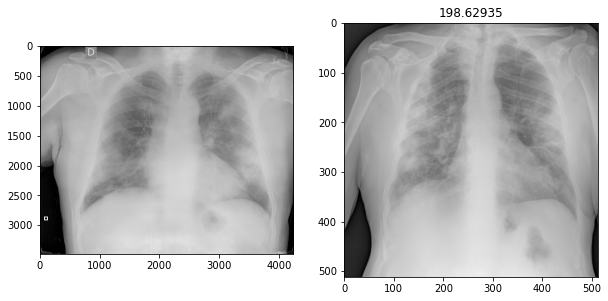

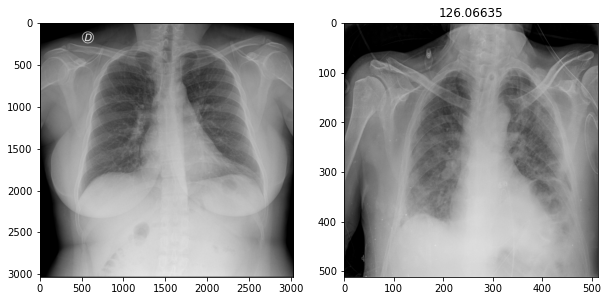

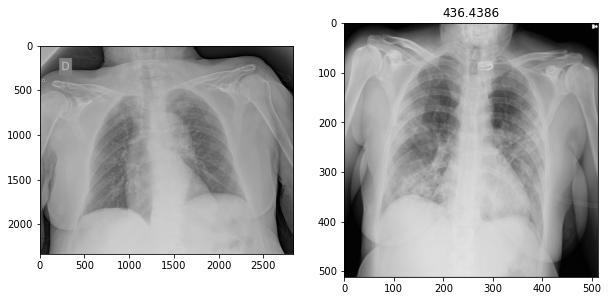

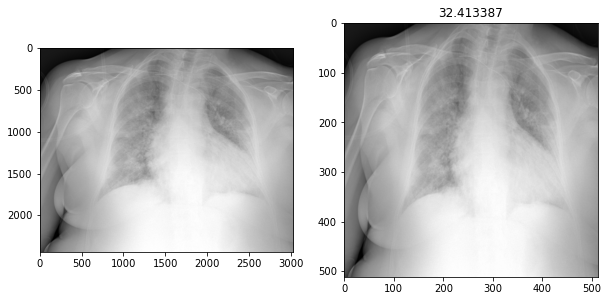

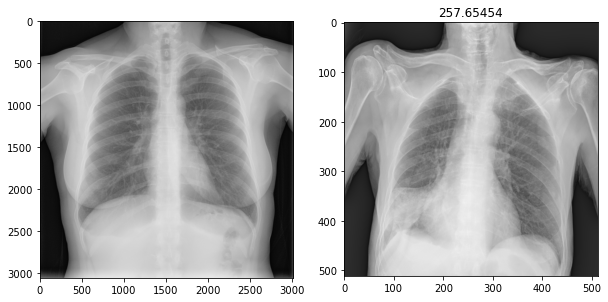

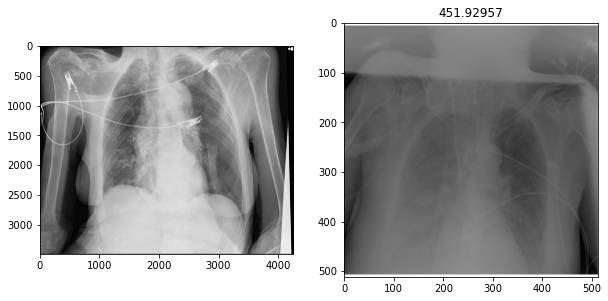

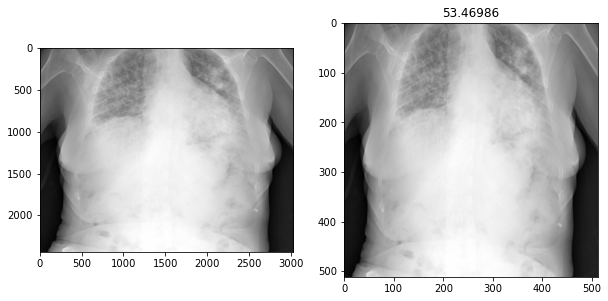

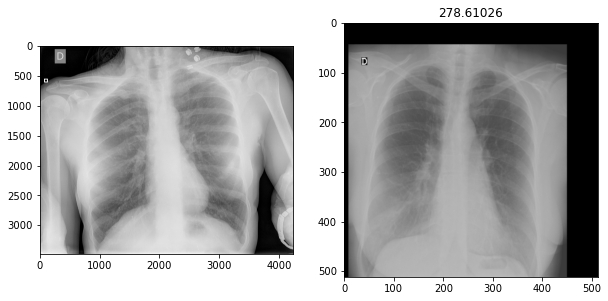

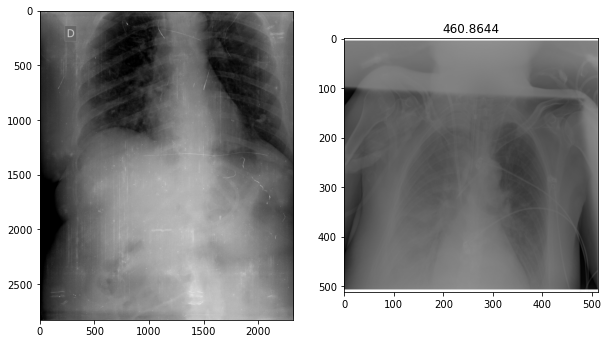

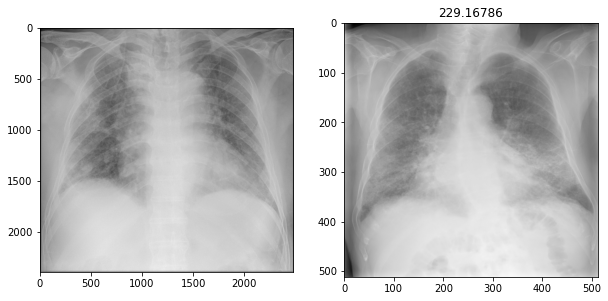

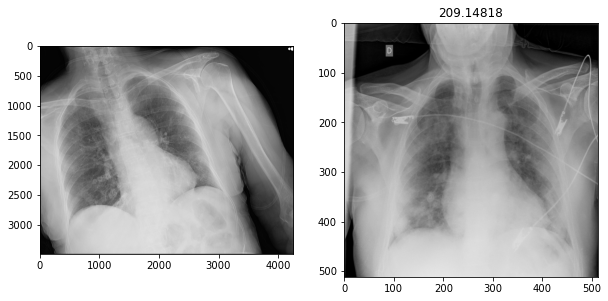

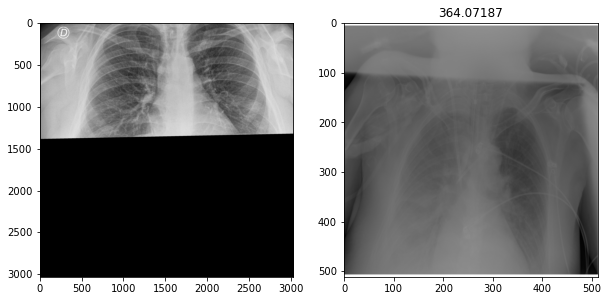

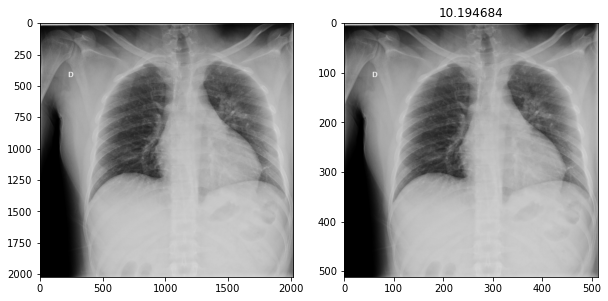

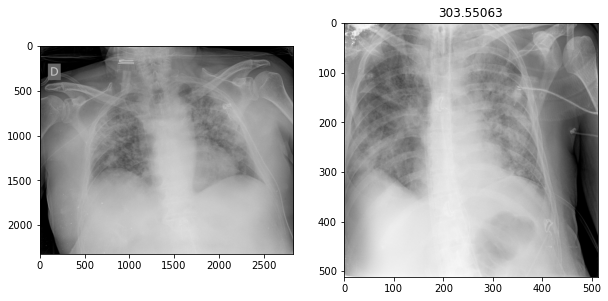

In [76]:
cnt = 0
for original_img_num in range(20000):

    if np.abs(bimcv_img_array - original_img_array[original_img_num]).mean(1).min() < 500:
        ind = np.abs(bimcv_img_array - original_img_array[original_img_num]).mean(1).argsort()[0]

        plt.figure(figsize=(10, 12))

        original_img = cv2.imread(df_original_agg.npy_path[original_img_num])
        target_img = cv2.imread(bimcv_path[ind])

        plt.subplot(1, 2, 1)
        plt.imshow(original_img)

        plt.subplot(1, 2, 2)
        plt.imshow(target_img)
        plt.title(np.abs(bimcv_img_array - original_img_array[original_img_num]).mean(1).min())
        plt.show()
        
        if cnt > 20:
            break
        else:
            cnt += 1